In [11]:
import seaborn as sns
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

## Extract results from log files and create a dataframe

In [17]:
method_folder = ['all_drugs_with_error_bar', 'moli','holi_only__more_sobol', 'holi_moli_saasbo_50_sobol',
                 'holi_moli_gp_30_sobol', 'bo-moli', 'small_search_space']
logfile_name = 'rerun_results.txt'
auroc_columns = ['Drug', 'Dataset', 'Auroc', 'Method']
auprc_columns = ['Drug', 'Dataset', 'Auprc', 'Method']
auroc_table_columns = ['Drug', 'Dataset', 'Auroc', 'Method']
auprc_table_columns = ['Drug', 'Dataset', 'Auprc', 'Method']

auroc_result_dataframe = pd.DataFrame(columns=auroc_columns)
auprc_result_dataframe = pd.DataFrame(columns=auprc_columns)
result_path = Path('..', 'results', 'bayesian_optimisation')

drug_paths =  [x for x in result_path.iterdir()]
for drug_path in drug_paths:
    drug = drug_path.stem
    if drug in ('EGFR', 'ensemble'):
        continue
    for logfile_folder in method_folder:
        method = logfile_folder
        log_path = drug_path / logfile_folder / logfile_name
        test_aupcr = []
        extern_auprc = []
        if log_path.is_file():
            with open(log_path, 'r') as log_file:
                for line in log_file:
                    if 'test auroc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        test_auroc = [float(number) for number in numbers.split(',')]
                    if 'extern auroc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        extern_auroc = [float(number) for number in numbers.split(',')]
                    if 'test auprc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        test_aupcr = [float(number) for number in numbers.split(',')]
                    if 'extern auprc list' in line:
                        numbers = line.partition('[')[2].partition(']')[0]
                        extern_auprc = [float(number) for number in numbers.split(',')]
                    if 'skill predictor' in line:
                        no_skill_auprc = float(line.split(':')[-1])
                    if 'test auroc mean' in line:
                        test_auroc_mean = float(line.split(':')[-1])
                    if 'test auroc std' in line:
                        test_auroc_std = float(line.split(':')[-1])
                    if 'test_auprc mean' in line:
                        test_auprc_mean = float(line.split(':')[-1])
                    if 'test_auprc std' in line:
                        test_auprc_std = float(line.split(':')[-1])
                    
                        
                for auroc in test_auroc:
                    auroc_result_dataframe = auroc_result_dataframe.append(
                        pd.DataFrame([[drug, 'Test', auroc, method]], columns=auroc_columns))
                for auroc in extern_auroc:
                    auroc_result_dataframe = auroc_result_dataframe.append(
                        pd.DataFrame([[drug, 'Extern', auroc, method]], columns=auroc_columns))
                for auprc in test_aupcr:
                    auprc_result_dataframe = auprc_result_dataframe.append(
                        pd.DataFrame([[drug, 'Test', auprc, method]], columns=auprc_columns))
                for auprc in extern_auprc:
                    auprc_result_dataframe = auprc_result_dataframe.append(
                        pd.DataFrame([[drug, 'Extern', auprc, method]], columns=auprc_columns))

## Get ensemble results

In [13]:
ensemble_path = result_path / 'ensemble'
method_paths = ['bo-holimoli']

for method_path in method_paths:
    drug_paths =  [x for x in (ensemble_path / method_path).iterdir()]
    for drug_path in drug_paths:
        drug = drug_path.stem
        log_path = drug_path / 'logs.txt'
        if log_path.is_file():
            with open(log_path, 'r') as log_file:
                for line in log_file:
                    if 'Weighted' in line:
                        weighted_auroc = float(line.split("=")[-1].strip())
                        auroc_result_dataframe = auroc_result_dataframe.append(
                        pd.DataFrame([[drug, 'Extern', weighted_auroc, 'Weighted Ensemble']],
                                         columns=auroc_columns))

## Get no skill predictor auprc

## Beautify strings

In [14]:
auroc_result_dataframe = auroc_result_dataframe.replace('all_drugs_with_error_bar', 'Bo-Holi-MOLI')
auroc_result_dataframe = auroc_result_dataframe.replace('holi_only__more_sobol', 'Random-Holi-MOLI')
auroc_result_dataframe = auroc_result_dataframe.replace('moli', 'MOLI')
auroc_result_dataframe = auroc_result_dataframe.replace('holi_moli_saasbo_50_sobol', 'SAASBO')
auroc_result_dataframe = auroc_result_dataframe.replace('holi_moli_gp_30_sobol', 'Holi-Moli-more-Sobol')
auroc_result_dataframe = auroc_result_dataframe.replace('Gemcitabine_pdx', 'Gemcitabine with PDX')
auroc_result_dataframe = auroc_result_dataframe.replace('Gemcitabine_tcga', 'Gemcitabine with TCGA')

auprc_result_dataframe = auprc_result_dataframe.replace('all_drugs_with_error_bar', 'Bo-Holi-MOLI')
auprc_result_dataframe = auprc_result_dataframe.replace('holi_only__more_sobol', 'Random-Holi-MOLI')
auprc_result_dataframe = auprc_result_dataframe.replace('moli', 'MOLI')
auprc_result_dataframe = auprc_result_dataframe.replace('holi_moli_saasbo_50_sobol', 'SAASBO')
auprc_result_dataframe = auprc_result_dataframe.replace('holi_moli_gp_30_sobol', 'Holi-Moli-more-Sobol')
auprc_result_dataframe = auprc_result_dataframe.replace('Gemcitabine_pdx', 'Gemcitabine with PDX')
auprc_result_dataframe = auprc_result_dataframe.replace('Gemcitabine_tcga', 'Gemcitabine with TCGA')

auroc_result_dataframe.to_csv('auroc_results')
auprc_result_dataframe.to_csv('auprc_results')

## Plot categorical auroc boxplots

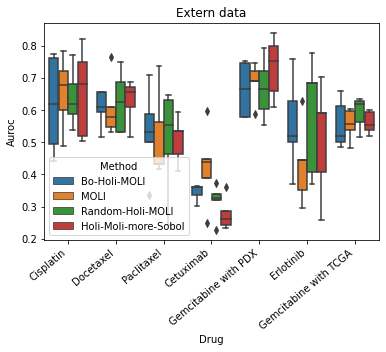

In [15]:
test_results = auroc_result_dataframe[auroc_result_dataframe['Dataset'] == 'Test']
extern_results = auroc_result_dataframe[auroc_result_dataframe['Dataset'] == 'Extern']
boxplot_test = sns.boxplot(x='Drug', y='Auroc', hue='Method',  data=test_results)
boxplot_test.set_xticklabels(boxplot_test.get_xticklabels(), rotation=40, ha="right")
plt.title('Test data')
plt.savefig('auroc_boxplot_test.pdf', bbox_inches="tight")
plt.clf()

boxplot_extern = sns.boxplot(x='Drug', y='Auroc', hue='Method',  data=extern_results)
boxplot_extern.set_xticklabels(boxplot_extern.get_xticklabels(), rotation=40, ha="right")
plt.title('Extern data')
plt.savefig('auroc_boxplot_extern.pdf', bbox_inches="tight")

## Create Auroc table

## Create Auprc table

## Show time differences